In [37]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt


detection_path = '/data2/thesis_exp/bimo_two_stage_5f/201007_testing/2022-06-29-11-27-33-test-201007/npz_output'

# bag1_radar_path = '/data2/itri/DCV/single_sensor_data/bag1/radar_lidar_overlay'
# bag2_radar_path = '/data2/itri/DCV/single_sensor_data/bag2/radar_lidar_overlay'
bag1_radar_path = '/home/ee904/NCTU/research/itri_related/20201007/code/overlay/bag1_overlay_test'
bag2_radar_path = '/home/ee904/NCTU/research/itri_related/20201007/code/overlay/bag2_overlay_test'

test_anno_path = '/data2/thesis_exp/bimo_two_stage_5f/201007_testing/2022-06-29-11-27-33-test-201007/test.json'

# output_path = '/home/ee904/NCTU/research/itri_related/20201007/code/livoxGt_radarDet'
output_path = '/home/ee904/NCTU/research/itri_related/20201007/code/draw_anno_detection/tmp_bbox'

detection_file = sorted(os.listdir(detection_path))
bag1_radar_file = sorted(os.listdir(bag1_radar_path))
bag2_radar_file = sorted(os.listdir(bag2_radar_path))

coco_test = COCO(test_anno_path)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [7]:
len(bag1_radar_file)
len(bag2_radar_file)

# anno_file[-1]

6919

#### util code

In [19]:
from imgaug.augmentables import BoundingBox, Polygon, Keypoint
from matplotlib.pyplot import get_cmap

def rotate_bbox(x, y, w, h, angle):
    c, s = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    R = np.asarray([[c, s], [-s, c]])
    pts = np.asarray(
        [[-w / 2, -h / 2],
         [w / 2, -h / 2],
         [w / 2, h / 2],
         [-w / 2, h / 2]])
    rot_pts = []
    for pt in pts:
        rot_pts.append(([x, y] + pt @ R).astype(int))
    return rot_pts

In [62]:
# score_threshold = 0.2
font_size = 12
alpha = 0.7
# cm = get_cmap('Set2')
cm = get_cmap('gist_rainbow')
classes = [1, 2, 3, 4]

cmap = [
		[int(y * 255.0) for y in cm(1.0 * x / len(classes))[: 3]]
		for x in range(len(classes))]
# cmap = [(x[1], x[2], x[0]) for x in cmap]
# cmap = [x[::-1] for x in cmap]
cmap = [(x[0], x[2], x[1]) for x in cmap]
cmap = [
	(0, 0, 255),
	(0, 255, 0),
	(255, 150, 0)
	# (60, 103, 155)
	# (255, 0, 165)
	# (255, 255, 0)
]

def draw_rotated_boxes(gt_img, gt_boxes, gt_classes,
													pred_img, pred_boxes, pred_scores, pred_classes, color_idx):

		# sungting
		gt_boxes[:, -1] -= 90
		pred_boxes[:, -1] -= 90

		for i in range(gt_boxes.shape[0]):
				cid = int(gt_classes[i])
				rot_pts = np.array(rotate_bbox(*gt_boxes[i]))
				contours = np.array(
						[rot_pts[0],
							rot_pts[1],
							rot_pts[2],
							rot_pts[3]])
				# bb.label = self.classes[cid]['name']
				cv2.polylines(
						gt_img,
						[contours],
						isClosed=True,
						# color=self.cmap[cid],
						color=(255, 255, 255),
						thickness=4,
						lineType=cv2.LINE_AA)

				poly = Polygon(
						np.array(contours, dtype=np.int32).reshape(-1, 2))

				# gt_img = poly.to_bounding_box().draw_label_on_image(
				# 		gt_img,
				# 		self.cmap[cid],
				# 		size_text=self.font_size,
				# 		alpha=self.alpha,
				# 		height=self.font_size + 4)
		
		single_img = gt_img.copy()

		for i in range(pred_boxes.shape[0]):
				cid = int(pred_classes[i])
				# cid = color_idx
				rot_pts = np.array(rotate_bbox(*pred_boxes[i]))
				contours = np.array(
						[rot_pts[0],
							rot_pts[1],
							rot_pts[2],
							rot_pts[3]])

				# bb.label = f"{self.classes[int(cid)]['name']}: {pred_scores[i]:.2f}"
				poly = Polygon(
						np.array(contours, dtype=np.int32).reshape(-1, 2))
						# label=f"{pred_scores[i]:.2f}")
						# label=f"{self.classes[int(cid)]['name']}: {pred_scores[i]:.2f}")
				# pred_img = poly.draw_on_image(pred_img, self.cmap[cid], alpha=self.alpha, )

				cv2.polylines(
						pred_img,
						[contours],
						isClosed=True,
						color=cmap[cid],
						thickness=(2),
						lineType=cv2.LINE_AA)

				# pred_img = poly.to_bounding_box().draw_label_on_image(
				# 		pred_img,
				# 		cmap[cid],
				# 		size_text=font_size,
				# 		alpha=alpha,
				# 		height=font_size + 4)

				cv2.polylines(
						single_img,
						[contours],
						isClosed=True,
						color=cmap[cid],
						thickness=(2),
						lineType=cv2.LINE_AA)
				
				# print('cmap: ', cmap[cid])
				# print('id: ', cid)

				# single_img = poly.to_bounding_box().draw_label_on_image(
				# 		single_img,
				# 		cmap[cid],
				# 		size_text=font_size,
				# 		alpha=alpha,
				# 		height=font_size + 4)
				
		return pred_img, gt_img, single_img

In [21]:
def draw_anno_boxes(img, anno_data):
	anno_data = anno_data.reshape(-1, 6)
	try:
		anno_data = anno_data[:, 1:]
	except:
		print('error: ')
		print(anno_data)
	
	anno_data[:, 0] -= 640
	anno_data[:, 0] += 1142/4

	anno_data[:, 1] += 1142/2

	# anno_data[:, 0] -= anno_data[:, 2]//2
	# anno_data[:, 1] -= anno_data[:, 3]//2

	anno_data[:, 4] = anno_data[:, 4] * 180 / np.pi

	for i in range(anno_data.shape[0]):
		rot_pts = np.array(rotate_bbox(*anno_data[i]))
		contours = np.array(
						[rot_pts[0],
							rot_pts[1],
							rot_pts[2],
							rot_pts[3]])
		cv2.polylines(
						img,
						[contours],
						isClosed=True,
						color=(255, 255, 255),
						thickness=(2),
						lineType=cv2.LINE_AA)

	return img

In [22]:
import numpy as np

def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

#### draw bboxes

In [125]:
nms_threshold = 0.1
conf_threshold = 0.25

for i, d in enumerate(tqdm(detection_file)):
	if int(anno_file[i][:-4]) < 16377276538367:
		continue
	# if '16377276538367' not in anno_file[i]:
	# 	continue

	# print('in')

	det_data = np.load(os.path.join(
		detection_path,
		d
	))

	conf_selection = (det_data['pred_scores'] > conf_threshold)

	pred_boxes = det_data['pred_boxes'][conf_selection]
	pred_boxes_score = det_data['pred_scores'][conf_selection]
	pred_boxes_class = det_data['pred_classes'][conf_selection]

	selection_prep = np.hstack((
		(pred_boxes[:, 0]).reshape(-1, 1),
		(pred_boxes[:, 1]).reshape(-1, 1),
		(pred_boxes[:, 0]+pred_boxes[:, 2]).reshape(-1, 1),
		(pred_boxes[:, 1]+pred_boxes[:, 3]).reshape(-1, 1),
		pred_boxes_class.reshape(-1, 1)
	))

	selection = nms(selection_prep, nms_threshold)

	# break

	anno_data = np.loadtxt(os.path.join(anno_path, anno_file[i]), delimiter=' ')

	# break




	# print(det_data.files)
	# print(det_data['pred_scores'].shape)

	radar_img = cv2.imread(os.path.join(radar_path, radar_file[i]))


	# ret = draw_rotated_boxes(radar_img, det_data['gt_boxes'], det_data['gt_classes'], 
	# 										radar_img.copy(), det_data['pred_boxes'], det_data['pred_scores'], det_data['pred_classes'], 0)

	ret = draw_rotated_boxes(radar_img, det_data['gt_boxes'], det_data['gt_classes'], 
											radar_img.copy(), pred_boxes[selection], pred_boxes_score[selection], pred_boxes_class[selection], 0)

	new_ret = draw_anno_boxes(ret[-1], anno_data)
	
	cv2.imwrite(os.path.join(out_path, radar_file[i]), new_ret)


	# if i == 10:
	# 	break

100%|██████████| 1372/1372 [00:17<00:00, 80.62it/s]  


#### 201007

In [65]:
nms_threshold = 0.1
conf_threshold = 0.25

for i, dct in enumerate(tqdm(coco_test.imgs.values())):
	fname = dct['file_name']
	base_name = fname.split('/')[-1]
	prefix = None

	if 'bag1' in fname:
		radar_img = cv2.imread(os.path.join(
			bag1_radar_path,
			base_name
		))
		prefix = 'bag1_'

	elif 'bag2' in fname:
		radar_img = cv2.imread(os.path.join(
			bag2_radar_path,
			base_name
		))
		prefix = 'bag2_'
	
	else:
		raise ValueError('Unknown input')

	det_data = np.load(os.path.join(
		detection_path,
		detection_file[i]
	))

	conf_selection = (det_data['pred_scores'] > conf_threshold)

	pred_boxes = det_data['pred_boxes'][conf_selection]
	pred_boxes_score = det_data['pred_scores'][conf_selection]
	pred_boxes_class = det_data['pred_classes'][conf_selection]

	selection_prep = np.hstack((
		(pred_boxes[:, 0]).reshape(-1, 1),
		(pred_boxes[:, 1]).reshape(-1, 1),
		(pred_boxes[:, 0]+pred_boxes[:, 2]).reshape(-1, 1),
		(pred_boxes[:, 1]+pred_boxes[:, 3]).reshape(-1, 1),
		pred_boxes_class.reshape(-1, 1)
	))

	selection = nms(selection_prep, nms_threshold)


	ret = draw_rotated_boxes(radar_img, det_data['gt_boxes'], det_data['gt_classes'], 
										radar_img.copy(), pred_boxes[selection], pred_boxes_score[selection], pred_boxes_class[selection], 0)
	
	# break
	cv2.imwrite(os.path.join(output_path, prefix+base_name), ret[-1])
	
	# plt.imshow(ret[-1])
	# break

100%|██████████| 3212/3212 [04:39<00:00, 11.48it/s]


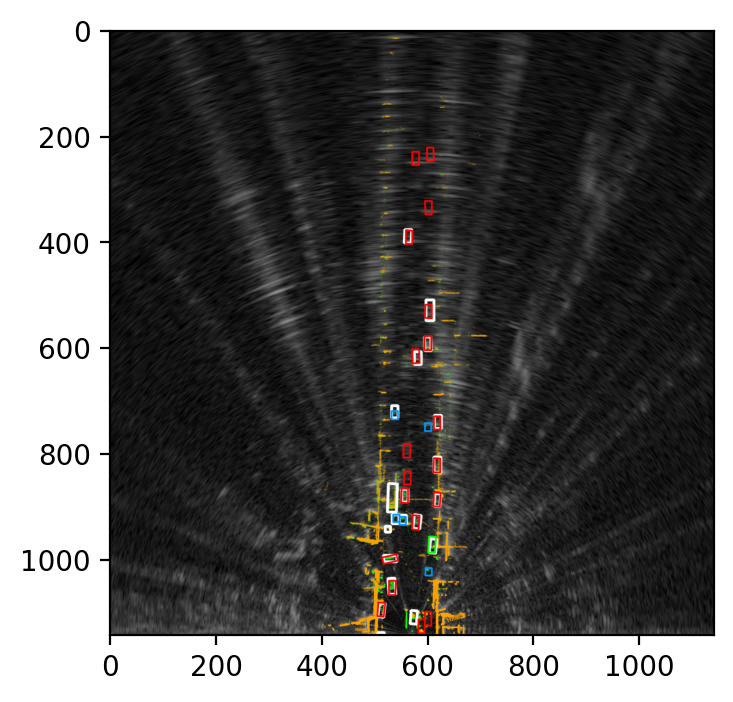

In [64]:
plt.rcParams['figure.dpi'] = 200
plt.imshow(ret[-1][:,:,::-1])
